# Barnard 5 figures

In [1]:
import numpy as np
from astropy.modeling.models import Gaussian1D
import astropy.units as u
from astropy.wcs import WCS
from astropy.io import fits
import os
import regions
from spectral_cube import SpectralCube
from B5setup import *

%matplotlib inline
import matplotlib.pyplot as plt
import aplpy
from matplotlib.patches import Circle, Ellipse

In [2]:
# definition of constants and fuctions

def degtohoursRA(deg):
    hours = deg / 360 * 24
    hh = np.trunc(hours).astype('int64')
    minutes = ((hours-hh) % 60) * 60
    mm = np.trunc(minutes).astype('int64')
    seconds = ((minutes-mm) % 60) * 60
    ss = np.round(seconds, 2)
    return '{0:02d}:{1:02d}:{2:0>5}'.format(hh, mm, ss)


def degtohoursDEC(deg):
    dd = np.trunc(deg).astype('int64')
    minutes = ((np.abs(deg)-np.abs(dd)) % 60) * 60
    mm = np.trunc(minutes).astype('int64')
    seconds = ((minutes-mm) % 60) * 60
    ss = np.round(seconds, 2)
    return '{0:02d}:{1:02d}:{2:0>5}'.format(dd, mm, ss)

def hourstodegRA(hours, minutes, seconds):
    deg = 15 * hours + 60 * minutes + 60 * seconds    
    return deg

def degtodegDEC(degrees, minutes, seconds):
    deg = degrees + 60 * minutes + 60 * seconds    
    return deg

def getPositionFromRegions(regionfile):
    regionload = regions.read_ds9(regionfile)
    positions = [[regionload[i].center.ra.value, regionload[i].center.dec.value] for i in range(len(regionload))]
    regionlabels = [regionload[i].meta['label'] for i in range(len(regionload))]
    return positions, regionlabels

def get_spectra(cube, position, velstart, velend):
    '''
    Extracts the spectra (velocity, intensity) given a cube.
    
    Returns the spectra of the cube given, in the native units of the cube. 
    
    Args:
        cube (SpectralCube): datacube 
        position (NDarray): array size 2 containing ra and dec
        velstart (astropy.units): initial velocity of the spectra in u.km/u.s
        velend (astropy.units): final velocity of the spectra in u.km/u.s
    '''
    cubenew = cube.spectral_slab(velstart, velend)
    cubehead = cubenew.header
    bmaj = cubehead['bmaj'] * u.deg
    bmin = cubehead['bmin'] * u.deg
    beamarea = (1.133 * bmaj * bmin).to(u.arcsec**2)
    if 'restfreq' in cubehead._keyword_indices:
        restfreq = cubehead['restfreq'] * u.Hz
    else:
        restfreq = cubehead['restfrq'] * u.Hz
    cubewcs = WCS(cubehead)
    ra, dec = cubewcs.celestial.all_world2pix(position[0], position[1], 0)
#     rah = degtohoursRA(position[0])
#     dech = degtohoursDEC(position[1])
    velocities = cubenew.spectral_axis
    intensities = cubenew[:, int(dec), int(ra)]
    return velocities, intensities

def get_parameters_spectra(paramcube, position, header):
    '''
    This function returns all the contents in the cube along the spectra. 
    This means it returns errors as well if the paramscube includes them
    
    Args:
        paramcube (ndarray): cube with the parameters and errors for each parameter
        position (NDarray): array size 2 containing ra and dec in degrees
        header (SpectralCube.header): header to transform the wcs into pixel positions
    '''
    cubewcs = WCS(header)
    ra, dec = cubewcs.celestial.all_world2pix(position[0], position[1], 0)
    params = paramcube[:, int(dec), int(ra)]
    return params


## Filenames

In [3]:
fitdir = 'gaussfit/'
figdir = 'figures/'


In [107]:
# HC3N files
# File in K and in km/s
imagefile = "B5-NOEMA+30m-H3CN-10-9_cut_K"
imagefile_87 = "B5-NOEMA+30m-H3CN-8-7_cut_K"
smallimagefile = "B5-NOEMA+30m-H3CN-10-9_cut_K_B5zoom"
x0, y0, x1, y1 = 83, 131, 133, 180
mom0file = imagefile + '.mom0.fits'
mom0file87 = imagefile_87 + '_int_9.2_11.2'

rmsKkmsHC3N = 0.15
rmsfile = fitdir + imagefile + '_rms'
snrfile = fitdir + imagefile + '_snr'
tpeakfile = fitdir + imagefile + '_Tpeak'
maskfile = fitdir + imagefile + '_mask'
initguessfile = fitdir + imagefile + '_guesses.fits'
vlsrdifffile = fitdir + 'B5_Vlsr_HC3N_minus_NH3.fits'
vlsrdiffkdefile = fitdir + 'B5_Vlsr_HC3N_minus_NH3'
sigmavdifffile = fitdir + 'B5_SigmaV_HC3N_minus_NH3.fits'

fitfile =  fitdir + imagefile + '_1G_fitparams_2.fits'
fitfilefiltered = fitdir + imagefile + '_1G_fitparams_2_filtered.fits'
fitfilefiltered_vlsr = fitdir + imagefile + '_1G_fitparams_filtered_Vlsr.fits'

fitfile2 = fitdir + imagefile + '_B5zoom_2G_fitparams2.fits'
fitfile2filtered = fitdir + imagefile + '_B5zoom_2G_fitparams2_filtered.fits'

# line ratio map
ratiomapfile = 'B5-NOEMA+30m-H3CN-10-9_cut_K_int_9.2_11.2_convolved_regrid_over_8_7.fits'

In [5]:
# H2CO files
imagefileh2co = "B5-NOEMA+30m-H2CO-1-01-0-00_cut_K"
mom0h2cofile = imagefileh2co + '.mom0.fits'
fitfileh2co =  fitdir + imagefileh2co + '_1G_fitparams_2.fits'
fitfilefilteredh2co = fitdir + imagefileh2co + '_1G_fitparams_2_filtered.fits'

In [6]:
# VLA+GBT files from Pineda et al 2015
vlafolder = '../B5_wide_multiple/'
maskC1file = vlafolder + 'mask_C1.fits'
maskC2file = vlafolder + 'mask_C2.fits'
maskC3file = vlafolder + 'mask_C3.fits'
nh3mom0file = 'B5_VLA_GBT_model_11_mom0_reproject.fits'
nh3mom0levels = [0.1]
nh3velocityfile = fitdir + 'B5_VLA_GBT_model_vc_QA_reprojectHC3N.fits'
# MASSES survey files from Stephens et al 2019
massesfolder = 'MASSES_data/'
CO21fileblue = massesfolder + 'Per53.12CO21.robust1_blue.fits'
CO21filered = massesfolder + 'Per53.12CO21.robust1_red.fits'
bluecontlevels = [0.82+i*1.3 for i in range(4)]
redcontlevels = [1.2+i*2.1 for i in range(4)] # in Jy/beam km/s

## HC$_3$N (10 -- 9)

### Moment 0 images

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found w

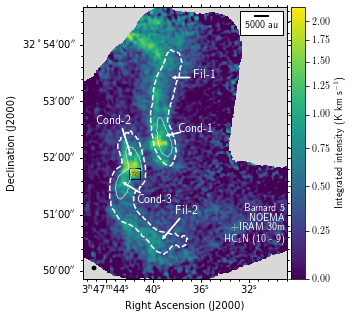

In [7]:
savefigure = True
fig = plt.figure(figsize=(5,5))
figname = figdir + imagefile + '_mom0_9.3_11.2.pdf'

gc = plot_aplpy_subfig(mom0file, fig, (1,1,1), 'arcsinh', 0, 2.2, 'viridis', vmid=0.8, showframeScalebar=True)
gc.show_contour(maskC1file, colors='w', linewidths=0.5)
gc.add_label(0.55, 0.55, 'Cond-1', relative=True, color='w', size=12)
gc.show_contour(maskC2file, colors='w', linewidths=0.5)
gc.add_label(0.15, 0.58, 'Cond-2', relative=True, color='w', size=12)
gc.show_contour(maskC3file, colors='w', linewidths=0.5)
gc.add_label(0.35, 0.29, 'Cond-3', relative=True, color='w', size=12)

gc.show_arrows([56.9071283, 56.9275561, 56.9212545, 56.9039327, 56.9074336], 
               [32.8742579, 32.8753517, 32.8564551, 32.8903704, 32.8489104], 
               [0.005, -0.003, 0.006, 0.006, 0.006], [-0.001, -0.008, 0.003, 0, -0.006], color='w', width=1, head_width=4, head_length=4)
# filament outline from NH3(1,1)
gc.show_contour(nh3mom0file, colors='w', linestyles='dashed', levels=nh3mom0levels, zorder=34)
gc.add_label(0.6, 0.75, 'Fil-1', relative=True, color='w', size=12)
gc.add_label(0.51, 0.25, 'Fil-2', relative=True, color='w', size=12)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.add_label(0.99,0.20, 'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', relative=True, color='w', size=10, horizontalalignment='right')
gc.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')

gc.show_rectangles([ra_yso], [dec_yso], 0.0015*2, 0.0015*2, edgecolor='k', facecolor='none')

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)


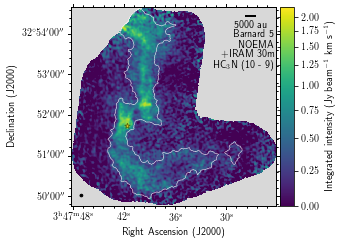

In [8]:
# image with intensity mask
fig = plt.figure(figsize=(4,4))
figname = figdir + imagefile + '_mom0_9.3_11.2_wmask.pdf'

gc = plot_aplpy_subfig(mom0file, fig, (1,1,1), 'arcsinh', 0, 2.2, 'viridis', vmid=0.8)
gc.show_contour(maskfile+'.fits', colors='white', linewidths=0.5, levels=[1])
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')


gc.add_label(0.99,0.78, 'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', relative=True, color='k', size=10, horizontalalignment='right')
fig.savefig(figname, bbox_inches='tight', dpi=300)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


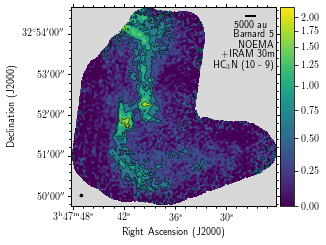

In [9]:
# image with moment 0 contours
fig = plt.figure(figsize=(4,4))
figname = figdir + imagefile + '_mom0_9.3_11.2_wcontintensity.pdf'

gc = plot_aplpy_subfig(mom0file, fig, (1,1,1), 'arcsinh', 0, 2.2, 'viridis', vmid=0.8)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)

gc.add_label(0.99,0.78, 'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', relative=True, color='k', size=10, horizontalalignment='right')
fig.savefig(figname, bbox_inches='tight', dpi=300)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


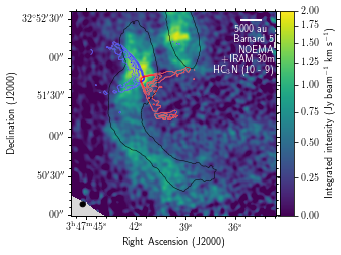

In [10]:
# zoom around IRS1

fig = plt.figure(figsize=(4,4))
figname = figdir + imagefile + '_mom0_9.3_11.2_south_woutflow_wcond.pdf'

gc = plot_aplpy_subfig(mom0file, fig, (1,1,1), 'arcsinh', 0, 2, 'viridis', vmid=0.8, label_col='w')
gc.recenter(56.9154585, 32.8549649, 0.0217241) #we focus on the south filament
# gc.show_contour(maskfile+'.fits', colors='white', linewidths=0.5, levels=[1])
gc.show_contour(CO21fileblue, levels=bluecontlevels, colors='b', linewidths=0.5, zorder=100)
gc.show_contour(CO21fileblue, levels=bluecontlevels, colors='w', linewidths=0.6)
gc.show_contour(CO21filered, levels=redcontlevels, colors='r', linewidths=0.5, zorder=100)
gc.show_contour(CO21filered, levels=redcontlevels, colors='w', linewidths=0.6)
gc.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
gc.add_label(0.99,0.78, 'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', relative=True, color='w', size=10, horizontalalignment='right')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')

fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


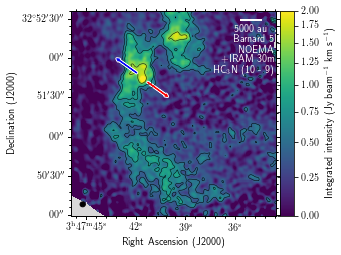

In [11]:
# zoom around IRS1 with moment 0 contours

fig = plt.figure(figsize=(4,4))
figname = figdir + imagefile + '_mom0_9.3_11.2_south_wcontintensity_woutflow.pdf'

gc = plot_aplpy_subfig(mom0file, fig, (1,1,1), 'arcsinh', 0, 2, 'viridis', vmid=0.8, label_col='w')
gc.recenter(56.9154585, 32.8549649, 0.0217241) #we focus on the south filament
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy beam$^{-1}$ km s$^{-1}$)')

gc.add_label(0.99,0.78, 'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', relative=True, color='w', size=10, horizontalalignment='right')
gc.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
gc.show_arrows(56.9249180, 32.8636213, 0.005, 0.003, color='w', zorder=100, linewidth=3)
gc.show_arrows(56.9249180, 32.8636213, 0.005, 0.003, color='b', zorder=100)
gc.show_arrows(56.9220945, 32.8616098, -0.005, -0.003, color='w', linewidth=3)
gc.show_arrows(56.9220945, 32.8616098, -0.005, -0.003, color='r', zorder=100)
fig.savefig(figname, bbox_inches='tight')

### Channel maps

In [12]:
cube_HC3N = SpectralCube.read(imagefile+'.fits').with_spectral_unit(u.km/u.s)
wcssky = WCS(cube_HC3N.header).celestial    
ra_yso_pix, dec_yso_pix = wcssky.wcs_world2pix(ra_yso, dec_yso, 0)
ra_yso_pix, dec_yso_pix = float(ra_yso_pix), float(dec_yso_pix)

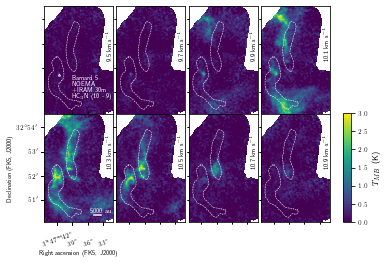

In [13]:
savefigure = True

velinit = 9.5 * u.km/u.s
deltav = 0.2 * u.km/u.s
figname = figdir + imagefile + '_chanmap_{0}_{1}.pdf'.format(velinit.value,deltav.value)
nrows = 2
ncols = 4
vmax = 3
vmin = 0
xmin = 60
xmax = 280
ymin = 26
ymax = 370
velocity_array = cube_HC3N.spectral_axis.value
velocity_sample = np.arange(velinit.value, velinit.value+(nrows*ncols*deltav.value), deltav.value) 
bmaj, bmin = np.array([cube_HC3N.header['BMAJ'], cube_HC3N.header['BMIN']])/np.abs(cube_HC3N.header['CDELT2'])
bpa = cube_HC3N.header['BPA'] - 90
scalebarsize = 5000
scalebarpix = int((scalebarsize / dist_B5.value) / 3600 / cube_HC3N.header['CDELT2'])

contourdata = fits.getdata(nh3mom0file)

fig, axlist = plt.subplots(nrows, ncols, sharex=True, sharey=True, figsize=(6,4), subplot_kw={'projection': wcssky})
axlist = axlist.flatten()
for i, ax in enumerate(axlist):
    indexvel = np.argmin(np.abs(velocity_array-velocity_sample[i]))
    planevel = cube_HC3N.unmasked_data[indexvel, :, :]
    im = ax.imshow(planevel, vmin = vmin, vmax=vmax)
    ax.annotate(str(np.round(velocity_sample[i], 2))+r' km s$^{-1}$', (0.9, 0.5), xycoords='axes fraction', color='k', size=6, rotation=90)
    beam = Ellipse((32, 29), bmaj, bmin, angle=bpa, ec = 'w', fc='w')
    ax.add_patch(beam)
    # ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    ax.contour(contourdata, levels=nh3mom0levels, colors='w', linewidths=0.5, linestyles='dashed')
    if i == 0:
        ax.scatter(ra_yso_pix, dec_yso_pix, marker='*', facecolor=None, edgecolor='w', s=8, linewidth=0.5) 
        ax.annotate('Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', (0.4, 0.15), xycoords='axes fraction', color='w', size=6)
        
    if not i == ncols*nrows - ncols:
        ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False, length=2)
        ax.tick_params(axis='y', which='both', left=True, labelleft=False, length=2)
    else:
        # ax.set_xlabel('Right ascension (FK5, J2000)')
        # ax.set_ylabel('Declination (FK5, J2000)')
        lon = ax.coords[0]
        lat = ax.coords[1]
        lon.set_axislabel('Right ascension (FK5, J2000)', size=6)
        lat.set_axislabel('Declination (FK5, J2000)', size=6)
        lat.set_ticklabel(size=6)
        lon.set_ticklabel(rotation=20,pad=15,ha='right', size=6)
        ax.plot([220, 220+scalebarpix], [50, 50], color='w', lw=1.5)
        ax.annotate(str(scalebarsize)+' au', (0.66, 0.09), xycoords='axes fraction', color='w', size=6)
        
fig.tight_layout(pad=0)
fig.subplots_adjust(left=0.2, right=0.98, bottom=0.15, top=0.9, hspace = 0, wspace=-0.4)
cbar_ax = fig.add_axes([0.95, 0.15, 0.02, 0.38])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label(label=r'$T_{MB}$ (K)', size=8)
cbar_ax.tick_params(labelsize=6)
# fig.subplots_adjust(hspace = 0, wspace=-0.5) 

if savefigure:
    fig.savefig(figname, dpi=300, bbox_inches='tight')
    

### Spectra of selected regions

In [14]:
cubeHC3N = SpectralCube.read(imagefile+'.fits').with_spectral_unit(u.km/u.s)
colorHC3N = '#984ea3'
positionfile = 'figures/B5_IRS1.reg'

        Use `regions.Regions.read` instead. [warnings]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0h1m2.3s' instead. [astropy.coordinates.angles]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


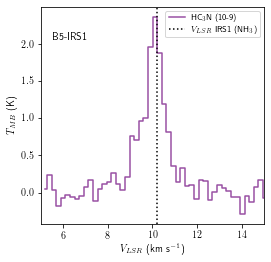

In [15]:
positions, labels = getPositionFromRegions(positionfile)
position = positions[0]
velinit = 5 * u.km/u.s
velend = 15 * u.km/u.s
label = 'B5-IRS1'
figname = figdir + imagefile + '_spectrum_B5IRS1.pdf'

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(cubeHC3N, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.21, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
ax.legend(fontsize=8)
fig.savefig(figname, bbox_inches='tight', dpi=300)

### Results of the Gaussian fit to HC$_3$N

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found w

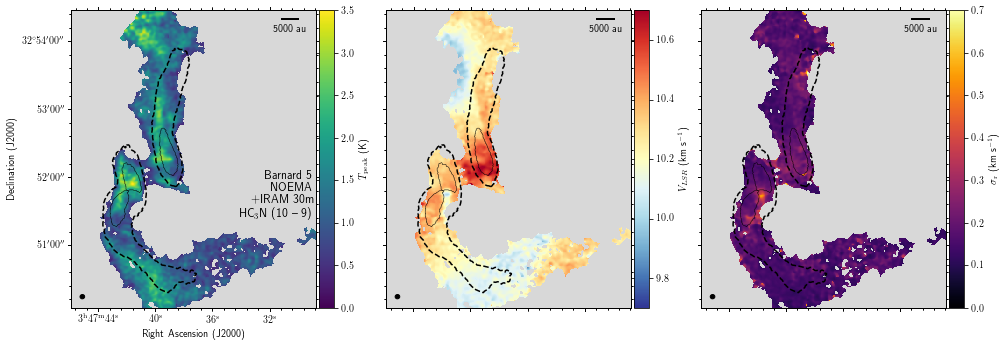

In [90]:
savefigure = True
fig = plt.figure(1, figsize=(16,8))
figname = figdir + imagefile + '_1G_fitparams_filtered_results.pdf'

cube = fits.getdata(fitfilefiltered)
paramscube = cube[:3]
errcube = cube[3:]
headerplot = fits.getheader(tpeakfile + '.fits')
stretch = 'linear'
vmin = [0, 10.2-0.5, 0]
vmax = [np.round(np.nanmax(paramscube[0]), 1), 10.2+0.5, np.round(np.nanmax(paramscube[2]), 1)]
cmap = ['viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$ (K)', r'$V_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{r}}$ (km s$^{-1}$)']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube[i], headerplot), fig, (1,3,i+1), stretch, \
                            vmin[i], vmax[i], cmap[i])
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(56.9055921,32.8711272,width=0.06,height=0.073)
    if i:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()
    else:
        ax0.add_label(0.99,0.38, 
                     'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 -- 9)', 
                     relative=True, color='k', size=12, horizontalalignment='right')
    
    ax0.show_contour(maskC1file, colors='k', linewidths=0.5)
    ax0.show_contour(maskC2file, colors='k', linewidths=0.5)
    ax0.show_contour(maskC3file, colors='k', linewidths=0.5)
    # filament outline from NH3(1,1)g
    ax0.show_contour(nh3mom0file, colors='k', linestyles='dashed', levels=nh3mom0levels, zorder=34)
        
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

#### Velocity fit results

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


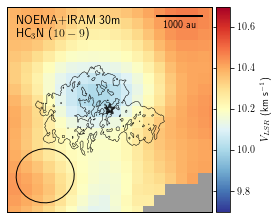

In [100]:
# velocity only with zoom into protostar
savefigure = True
figname = figdir + imagefile + '_1G_fitparams_filtered_vlsr_ALMAcontour.pdf'

fig = plt.figure(1, figsize=(4,4))
velmin = 10.2-0.5
velmax = 10.2+0.5


filenamecontour = '../B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_1G_fitparams_total_aicres.fits'
filenameheader = '../B5_IRS1_ALMA/gaussfit_H2CO/analysis_central_chans_masked/B5IRS1_H2COa_robust05_multi_3_cut_K_contcorrected_total_ncomponents.fits'
tpeak_h2coalma = fits.getdata(filenamecontour)[0]
tpeakheader = fits.getheader(filenameheader)
tpeak = np.where(~np.isnan(tpeak_h2coalma), 1,0)

ax = plot_aplpy_subfig(fitfilefiltered_vlsr, 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r', barsize=1000)

ax.tick_labels.set_xformat('hh:mm:ss.s')
ax.tick_labels.set_yformat('dd:mm:ss.s')
ax.ticks.hide()
ax.tick_labels.hide()
ax.axis_labels.hide()
ax.recenter(ra_yso, dec_yso, 0.002)
ax.beam.set_facecolor('None')
ax.show_contour(fits.PrimaryHDU(tpeak, tpeakheader), colors='k', levels=[0.5], linewidths=0.5)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100,linewidth=2)
ax.set_nan_color('0.6')
ax.add_label(0.05,0.9, 'NOEMA+IRAM 30m\nHC$_3$N ($10-9$)', 
                     relative=True, color='k', size=12, horizontalalignment='left')
ax.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


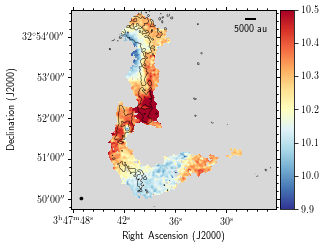

In [91]:
# velocity only with moment 0 contours
vlsrmap = paramscube[1]
headerplot = fits.getheader(fitdir + imagefile + '_1G_fitparams_filtered_Vlsr.fits')
fig = plt.figure(1, figsize=(4,4))
velmin = 9.9
velmax = 10.5
figname = figdir + imagefile + '_1G_fitparams_filtered_Vlsr.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(vlsrmap, headerplot), 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r')

ax.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([5,10]), linewidths=0.5)
fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


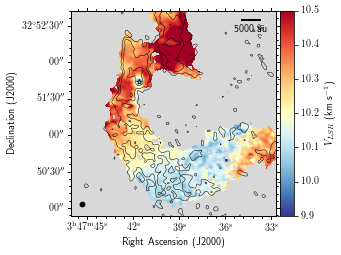

In [18]:
# velocity only with moment 0 contours, zoomed to to IRS1
vlsrmap = paramscube[1]
headerplot = fits.getheader(fitdir + imagefile + '_1G_fitparams_filtered_Vlsr.fits')
fig = plt.figure(1, figsize=(4,4))
velmin = 9.9
velmax = 10.5
figname = figdir + imagefile + '_1G_fitparams_filtered_Vlsr_south.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(vlsrmap, headerplot), 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r')
# ax.add_label(0.6, 0.04, 
#              r'$V_{\mathrm{LSR}}$', 
#              relative=True, family='sans-serif', size=12)
ax.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
ax.recenter(56.9139998, 32.8550135, 0.0234465)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found 

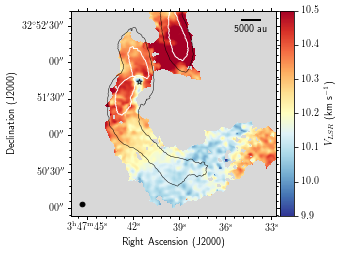

In [19]:
# velocity only with moment 0 and condensations in NH3
vlsrmap = paramscube[1]
headerplot = fits.getheader(fitdir + imagefile + '_1G_fitparams_filtered_Vlsr.fits')
fig = plt.figure(1, figsize=(4,4))
velmin = 9.9
velmax = 10.5
figname = figdir + imagefile + '_1G_fitparams_filtered_Vlsr_south_condensations.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(vlsrmap, headerplot), 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r')
ax.show_contour(maskC1file, colors='w', linewidths=1)
ax.show_contour(maskC2file, colors='w', linewidths=1)
ax.show_contour(maskC3file, colors='w', linewidths=1)
ax.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
ax.recenter(56.9139998, 32.8550135, 0.0234465)
fig.savefig(figname, bbox_inches='tight')

#### Fitted Velocity with respect to the central velocity of IRS1 from Pineda+15

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


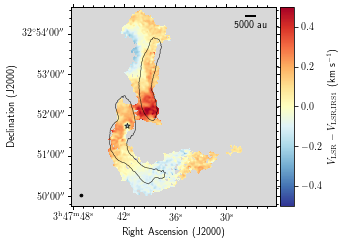

In [20]:
vlsr_irs1 = 10.2 #km/s
diffvlsr = paramscube[1] - vlsr_irs1
diffmin = -0.5
diffmax = 0.5
headerplot = fits.getheader(fitdir + imagefile + '_1G_fitparams_filtered_Vlsr.fits')
fig = plt.figure(1, figsize=(4,4))
figname = figdir + imagefile + '_1G_fitparams_filtered_Vlsr_minus_irs1.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(diffvlsr, headerplot), 
                       fig, (1,1,1), 'linear', diffmin, 
                       diffmax, 'RdYlBu_r')

ax.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.colorbar.set_axis_label_text(r'$V_{\mathrm{LSR}} - V_{\mathrm{LSR}, \mathrm{IRS1}}$ (km s$^{-1}$)')
fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


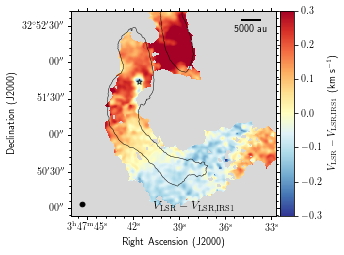

In [21]:
# zoomed near IRS1 with NH3 moment 0 contours
vlsr_irs1 = 10.2 #km/s
diffvlsr = paramscube[1] - vlsr_irs1
diffmin = -0.3
diffmax = 0.3
headerplot = fits.getheader(fitdir + imagefile + '_1G_fitparams_filtered_Vlsr.fits')
fig = plt.figure(1, figsize=(4,4))
figname = figdir + imagefile + '_1G_fitparams_filtered_Vlsr_minus_irs1_zoom.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(diffvlsr, headerplot), 
                       fig, (1,1,1), 'linear', diffmin, 
                       diffmax, 'RdYlBu_r')
ax.add_label(0.6, 0.04, 
             r'$V_{\mathrm{LSR}} - V_{\mathrm{LSR}, \mathrm{IRS1}}$', 
             relative=True, family='sans-serif', size=12)
ax.recenter(56.9139998, 32.8550135, 0.0234465)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.colorbar.set_axis_label_text(r'$V_{\mathrm{LSR}} - V_{\mathrm{LSR}, \mathrm{IRS1}}$ (km s$^{-1}$)')

ax.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


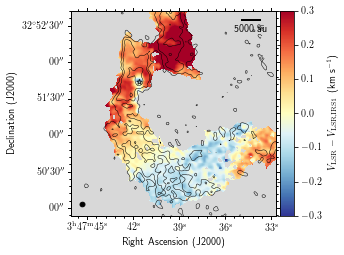

In [22]:
# zoomed near IRS1 with HC3N moment 0 contours
vlsr_irs1 = 10.2 #km/s
diffvlsr = paramscube[1] - vlsr_irs1
diffmin = -0.3
diffmax = 0.3
headerplot = fits.getheader(fitdir + imagefile + '_1G_fitparams_filtered_Vlsr.fits')
fig = plt.figure(1, figsize=(4,4))
figname = figdir + imagefile + '_1G_fitparams_filtered_Vlsr_minus_irs1_zoom_wcontmom0.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(diffvlsr, headerplot), 
                       fig, (1,1,1), 'linear', diffmin, 
                       diffmax, 'RdYlBu_r')
ax.recenter(56.9139998, 32.8550135, 0.0234465)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.colorbar.set_axis_label_text(r'$V_{\mathrm{LSR}} - V_{\mathrm{LSR}, \mathrm{IRS1}}$ (km s$^{-1}$)')

ax.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


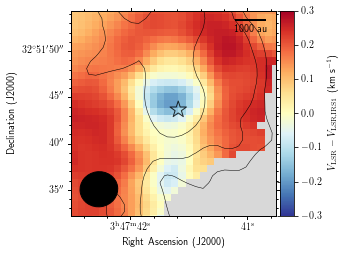

In [23]:
# zoomed near IRS1 with HC3N moment 0 contours where the 2G fit is made
vlsr_irs1 = 10.2 #km/s
diffvlsr = paramscube[1] - vlsr_irs1
diffmin = -0.3
diffmax = 0.3
headerplot = fits.getheader(fitdir + imagefile + '_1G_fitparams_filtered_Vlsr.fits')
fig = plt.figure(1, figsize=(4,4))
figname = figdir + imagefile + '_1G_fitparams_filtered_Vlsr_minus_irs1_zoomB5_wcontmom0.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(diffvlsr, headerplot), 
                       fig, (1,1,1), 'linear', diffmin, 
                       diffmax, 'RdYlBu_r', barsize=1000)
ax.recenter(56.9234601, 32.8620242, 0.0030777)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=300)
ax.colorbar.set_axis_label_text(r'$V_{\mathrm{LSR}} - V_{\mathrm{LSR}, \mathrm{IRS1}}$ (km s$^{-1}$)')

ax.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


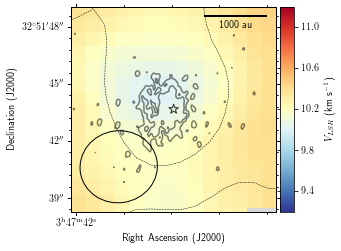

In [24]:
vlsrmap = paramscube[1]
headerplot = fits.getheader(fitdir + imagefile + '_1G_fitparams_filtered_Vlsr.fits')
fig = plt.figure(1, figsize=(4,4))
figname = figdir + imagefile + '_1G_fitparams_filtered_Vlsr_zoomALMA.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(vlsrmap, headerplot), 
                       fig, (1,1,1), 'linear', 10.2-1,10.2+1, 'RdYlBu_r', barsize=1000)
ax.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5, linestyles='dashed')
ax.recenter(ra_yso, dec_yso, 0.0015)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=100)
ax.show_contour('../B5_IRS1_ALMA/cleaned_images/B5IRS1_H2COa_robust05_multi_cut_mom0.fits', colors='k', alpha=0.5,levels=0.00586*np.array([3,5]))
ax.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
ax.beam.set_facecolor('None')
ax.colorbar.set_ticks([9.4,9.8,10.2,10.6,11])
fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)


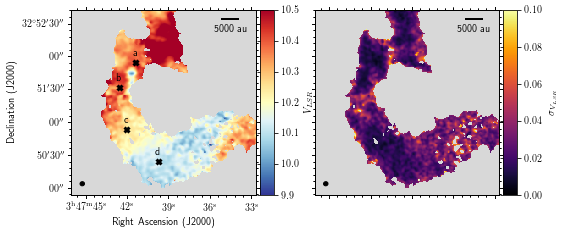

In [25]:
# velocity image with regions
fig = plt.figure(figsize=(8,8))
figname = figdir + imagefile + '_1G_fitparams_v_LSR_wregions.pdf'
positionfile = 'figures/samples_South.reg'

cube = fits.getdata(fitfilefiltered)
velocity = cube[1]
errvelocity = cube[4]
paramscube = [velocity, errvelocity]
headerplot = fits.getheader(tpeakfile + '.fits')
stretch = 'linear'
vmin = [9.9, 0]
vmax =[10.5, 0.1]
cmap = ['RdYlBu_r', 'inferno']
quantities = [r'$V_{LSR}$', r'$\sigma_{V_{LSR}}$']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube[i], headerplot), fig, (1,2,i+1), stretch, \
                            vmin[i], vmax[i], cmap[i])
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(56.9139998, 32.8550135, 0.0234465)
    if not i:
        ax0.show_regions(positionfile)
    if i:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()
        
fig.savefig(figname, bbox_inches='tight', dpi=300)

#### Velocity dispersion fit

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)


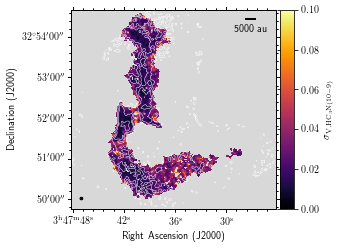

In [26]:
# velocity dispersion only with moment 0 contours
vlsrmap = paramscube[1]
headerplot = fits.getheader(fitdir + imagefile + '_1G_fitparams_filtered_SigmaV.fits')
fig = plt.figure(1, figsize=(4,4))
velmin = 0
velmax = 0.1
figname = figdir + imagefile + '_1G_fitparams_filtered_SigmaV_wcontmom0.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(vlsrmap, headerplot), 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'inferno')
ax.colorbar.set_axis_label_text(r'$\sigma_{\mathrm{V},\mathrm{HC}_3\mathrm{N}(10-9)}$')
ax.show_contour(mom0file, colors='w', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)


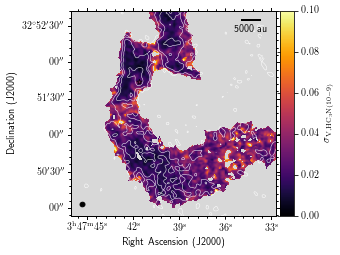

In [27]:
# velocity dispersion zoomed towards the south
vlsrmap = paramscube[1]
headerplot = fits.getheader(fitdir + imagefile + '_1G_fitparams_filtered_SigmaV.fits')
fig = plt.figure(1, figsize=(4,4))
velmin = 0
velmax = 0.1
figname = figdir + imagefile + '_1G_fitparams_filtered_SigmaV_wcontmom0_south.pdf'

ax = plot_aplpy_subfig(fits.PrimaryHDU(vlsrmap, headerplot), 
                       fig, (1,1,1), 'linear', velmin, 
                       velmax, 'inferno')

ax.show_contour(mom0file, colors='w', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
ax.recenter(56.9139998, 32.8550135, 0.0234465)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.colorbar.set_axis_label_text(r'$\sigma_{\mathrm{V},\mathrm{HC}_3\mathrm{N}(10-9)}$')
fig.savefig(figname, bbox_inches='tight')

### Spectra with the resulting fit

        Use `regions.Regions.read` instead. [warnings]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0h1m2.3s' instead. [astropy.coordinates.angles]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


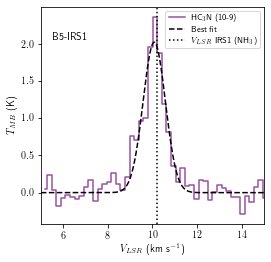

In [28]:
# fit results in B5-IRS1

cubeHC3N = SpectralCube.read(imagefile+'.fits').with_spectral_unit(u.km/u.s)
colorHC3N = '#984ea3'
positionfile = 'figures/B5_IRS1.reg'
positions, labels = getPositionFromRegions(positionfile)
paramsfile = fitfilefiltered
paramscube = fits.getdata(paramsfile)
position = positions[0]
velinit = 5 * u.km/u.s
velend = 15 * u.km/u.s
label = 'B5-IRS1'
figname = figdir + imagefile + '_spectrum_B5IRS1_wfit.pdf'

params = get_parameters_spectra(paramscube, position, cubeHC3N.header)
g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
vel = np.arange(velinit.value, velend.value, step=0.01)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(cubeHC3N, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.plot(vel, g1(vel), color='k', linestyle='dashed', label=r'Best fit')
ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.21, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
ax.legend(fontsize=8)
# fig.savefig(figname, bbox_inches='tight', dpi=300)

        Use `regions.Regions.read` instead. [warnings]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0h1m2.3s' instead. [astropy.coordinates.angles]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


0.4861762853271439 -0.5184942311958254


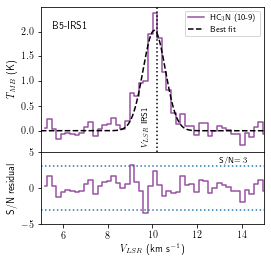

In [29]:
# fit with residuals
savefigure = True
positionfile = 'figures/B5_IRS1.reg'
rms = 0.15
cubeHC3N = SpectralCube.read(imagefile+'.fits').with_spectral_unit(u.km/u.s)
colorHC3N = '#984ea3'
positions, labels = getPositionFromRegions(positionfile)
paramsfile = fitfilefiltered
paramscube = fits.getdata(paramsfile)
position = positions[0]
velinit = 5 * u.km/u.s
velend = 15 * u.km/u.s
label = 'B5-IRS1'
figname = figdir + imagefile + '_spectrum_B5IRS1_wfit_wres.pdf'

params = get_parameters_spectra(paramscube, position, cubeHC3N.header)
g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
vel = np.arange(velinit.value, velend.value, step=0.01)

fig, [ax, ax2] = plt.subplots(2, 1, figsize=(4,4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
# ax = fig.add_subplot(211)


spectrum = get_spectra(cubeHC3N, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.plot(vel, g1(vel), color='k', linestyle='dashed', label=r'Best fit')
ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.21, color='k', linestyle='dotted')
ax.annotate(r'$V_{LSR}$ IRS1', (0.45, 0.04), xycoords='axes fraction', size=8, rotation=90)


# ax2 = fig.add_subplot(212)
ax2.plot(spectrum[0], (spectrum[1].value-g1(spectrum[0].value))/rms, drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.set_ylabel(r'$T_{MB}$ (K)')
ax2.set_ylabel('S/N residual')
ax2.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax2.set_ylim([-5, 5])
ax2.axhline(3, linestyle='dotted')
ax2.axhline(-3, linestyle='dotted')
ax.legend(fontsize=8)
ax2.annotate(r'S/N$=3$', (0.8, 0.85), xycoords='axes fraction', size=8)
fig.subplots_adjust(hspace=0)
if savefigure: fig.savefig(figname, bbox_inches='tight', dpi=300)
print(np.amax(spectrum[1].value-g1(spectrum[0].value)), np.amin(spectrum[1].value-g1(spectrum[0].value)))

        Use `regions.Regions.read` instead. [warnings]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0h1m2.3s' instead. [astropy.coordinates.angles]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


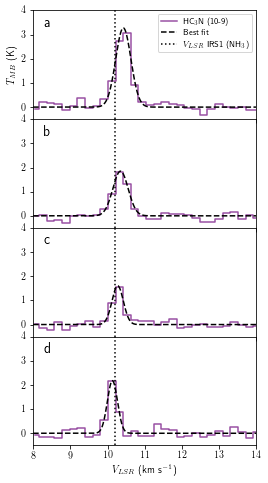

In [30]:
# fit along the hook
cubeHC3N = SpectralCube.read(imagefile+'.fits').with_spectral_unit(u.km/u.s)
colorHC3N = '#984ea3'
positionfile = 'figures/samples_South.reg'
positions, labels = getPositionFromRegions(positionfile)
paramsfile = fitfilefiltered
paramscube = fits.getdata(paramsfile)
velinit = 8 * u.km/u.s
velend = 14 * u.km/u.s
label = 'B5-IRS1'
figname = figdir + imagefile + '_spectra_wfit.pdf'
vel = np.arange(velinit.value, velend.value, step=0.01)

fig, axlist = plt.subplots(nrows=len(positions), ncols=1, figsize=(4,8), sharex='all')
fig.subplots_adjust(hspace=0)
axlist[len(axlist)-1].set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
axlist[0].set_ylabel(r'$T_{MB}$ (K)')

for ax, position, label in zip(axlist, positions, labels):
    params = get_parameters_spectra(paramscube, position, cubeHC3N.header)
    g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])

    spectrum = get_spectra(cubeHC3N, position, velinit, velend)
    ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
    ax.plot(vel, g1(vel), color='k', linestyle='dashed', label=r'Best fit')
    ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=14)
    ax.set_xlim([velinit.value, velend.value])
    ax.axvline(10.21, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
    ax.set_ylim([-0.5,4])
axlist[0].legend(fontsize=8)
fig.savefig(figname, bbox_inches='tight', dpi=300)

### Spectra after 2Gfit

        Use `regions.Regions.read` instead. [warnings]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0h1m2.3s' instead. [astropy.coordinates.angles]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


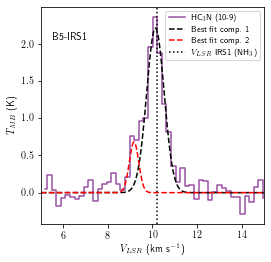

In [31]:
# fit results in B5-IRS1

cubeHC3N = SpectralCube.read(smallimagefile+'.fits').with_spectral_unit(u.km/u.s)
colorHC3N = '#984ea3'
positionfile = 'figures/B5_IRS1.reg'
positions, labels = getPositionFromRegions(positionfile)
paramsfile = fitfile2filtered
paramscube = fits.getdata(paramsfile)
position = positions[0]
velinit = 5 * u.km/u.s
velend = 15 * u.km/u.s
label = 'B5-IRS1'
figname = figdir + imagefile + '_spectrum_B5IRS1_wfit2G.pdf'

params = get_parameters_spectra(paramscube, position, cubeHC3N.header)
g1 = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
g2 = Gaussian1D(amplitude=params[3], mean=params[4], stddev=params[5])
vel = np.arange(velinit.value, velend.value, step=0.01)

fig = plt.figure(figsize=(4,4))
ax = fig.add_subplot(111)
ax.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
spectrum = get_spectra(cubeHC3N, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.plot(vel, g1(vel), color='k', linestyle='dashed', label=r'Best fit comp. 1')
ax.plot(vel, g2(vel), color='r', linestyle='dashed', label=r'Best fit comp. 2')
ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.21, color='k', linestyle='dotted', label=r'$V_{LSR}$ IRS1 (NH$_3$)')
ax.legend(fontsize=8)
fig.savefig(figname, bbox_inches='tight', dpi=300)

        Use `regions.Regions.read` instead. [warnings]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0h1m2.3s' instead. [astropy.coordinates.angles]
        Use another way of creating angles instead (e.g. a less ambiguous string like '-0d1m2.3s' instead. [astropy.coordinates.angles]


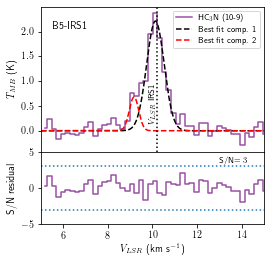

In [32]:

savefigure = True
figname = figdir + imagefile + '_spectrum_B5IRS1_wfit2G_wres.pdf'
# fit results in B5-IRS1

cubeHC3N = SpectralCube.read(smallimagefile+'.fits').with_spectral_unit(u.km/u.s)
colorHC3N = '#984ea3'
rms = 0.15
positionfile = 'figures/B5_IRS1.reg'
positions, labels = getPositionFromRegions(positionfile)
paramsfile1 = fitfilefiltered
paramsfile2 = fitfile2filtered
paramscube1 = fits.getdata(paramsfile1)
paramscube2 = fits.getdata(paramsfile2)
position = positions[0]
velinit = 5 * u.km/u.s
velend = 15 * u.km/u.s
label = 'B5-IRS1'

params2 = get_parameters_spectra(paramscube2, position, cubeHC3N.header)
g1 = Gaussian1D(amplitude=params2[0], mean=params2[1], stddev=params2[2])
g2 = Gaussian1D(amplitude=params2[3], mean=params2[4], stddev=params2[5])
g1big = Gaussian1D(amplitude=params[0], mean=params[1], stddev=params[2])
vel = np.arange(velinit.value, velend.value, step=0.01)

fig, [ax, ax2] = plt.subplots(2, 1, figsize=(4,4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
ax2.set_xlabel(r'$V_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel(r'$T_{MB}$ (K)')
ax2.set_ylabel('S/N residual')
spectrum = get_spectra(cubeHC3N, position, velinit, velend)
ax.plot(spectrum[0], spectrum[1], drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax.plot(vel, g1(vel), color='k', linestyle='dashed', label=r'Best fit comp. 1')
ax.plot(vel, g2(vel), color='r', linestyle='dashed', label=r'Best fit comp. 2')
ax.text(0.05, 0.85, label, horizontalalignment='left', transform=ax.transAxes, color='k', size=10)
ax.set_xlim([velinit.value, velend.value])
ax.axvline(10.21, color='k', linestyle='dotted')
ax.legend(fontsize=8)
ax2.axhline(-3, linestyle='dotted')
ax2.axhline(3, linestyle='dotted')
ax.annotate(r'$V_{LSR}$ IRS1', (0.48, 0.2), xycoords='axes fraction', size=8, rotation=90)


ax2.plot(spectrum[0], (spectrum[1].value - (g1(spectrum[0].value)+g2(spectrum[0].value)))/rms, drawstyle='steps-mid', color=colorHC3N, label=r'HC$_3$N (10-9)')
ax2.set_ylim([-5, 5])
ax2.annotate(r'S/N$=3$', (0.8, 0.85), xycoords='axes fraction', size=8)
fig.subplots_adjust(hspace=0)
if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

### Results of the 2 Gaussian fit to HC$_3$N

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered

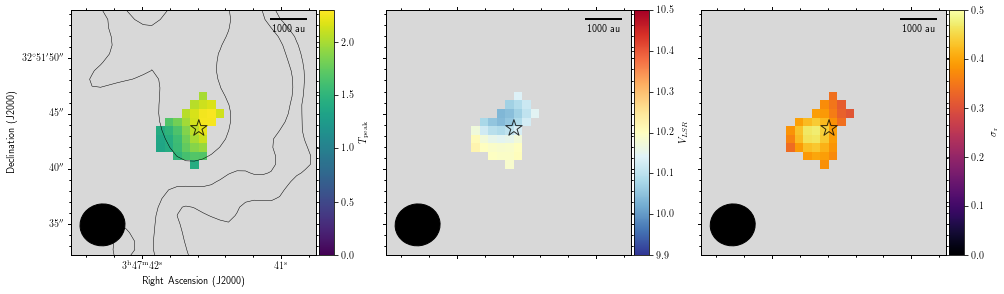

In [33]:
# strongest component
fig = plt.figure(1, figsize=(16,8))
figname = figdir + imagefile + '_B5zoom_2G_fitparams_filtered_resultscomp1.pdf'

cube = fits.getdata(fitfile2filtered)
paramscube = cube[:3]
cube = SpectralCube.read(smallimagefile+'.fits')
momentsmall = cube.moment()
headerplot = momentsmall.header
stretch = 'linear'
vmin = [0, 9.9, 0]
vmax = [np.round(np.nanmax(paramscube[0]), 1), 10.5, np.round(np.nanmax(paramscube[2]), 1)]
cmap = ['viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$', r'$V_{LSR}$', r'$\sigma_{\mathrm{r}}$']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube[i], headerplot), fig, (1,3,i+1), stretch, \
                            vmin[i], vmax[i], cmap[i], barsize=1000)
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(56.9234601, 32.8620242, 0.0030777)
    ax0.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=300)

    if i:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()
    elif not i:
        ax0.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
        
fig.savefig(figname, bbox_inches='tight', dpi=300)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered

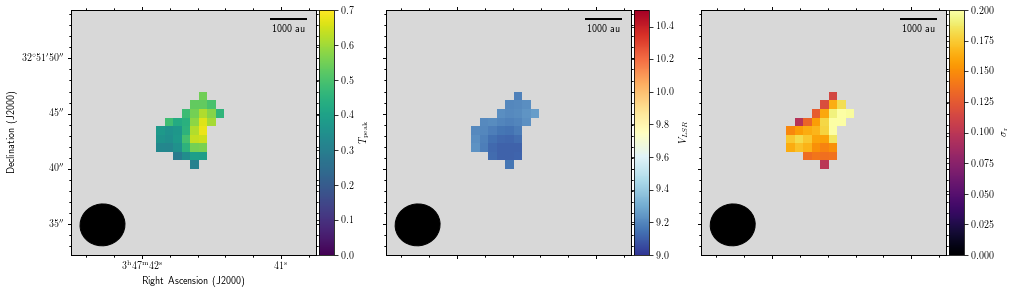

In [34]:
# Weakest component
fig = plt.figure(1, figsize=(16,8))
figname = figdir + imagefile + '_B5zoom_2G_fitparams_filtered_resultscomp2.pdf'

cube = fits.getdata(fitfile2filtered)
paramscube = cube[3:6]
cube = SpectralCube.read(smallimagefile+'.fits')
momentsmall = cube.moment()
headerplot = momentsmall.header
stretch = 'linear'
vmin = [0, 9.0, 0]
vmax = [np.round(np.nanmax(paramscube[0]), 1), 10.5, np.round(np.nanmax(paramscube[2]), 1)]
cmap = ['viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$', r'$V_{LSR}$', r'$\sigma_{\mathrm{r}}$']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube[i], headerplot), fig, (1,3,i+1), stretch, \
                            vmin[i], vmax[i], cmap[i], barsize=1000)
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(56.9234601, 32.8620242, 0.0030777)
    if i:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()
        
fig.savefig(figname, bbox_inches='tight', dpi=300)

#### Velocity of the 1G fit after replacing with the strongest component of the 2G fit

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


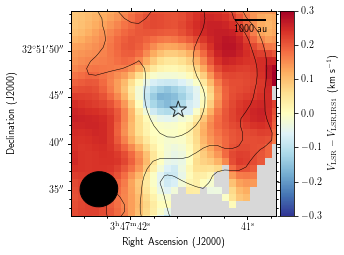

In [35]:
smallcubehookparamfile = fitfile2[:len(fitfile2)-6] + '_hookonlyparams.fits'
headerplot = momentsmall.header
params1g = fits.getdata(smallcubehookparamfile)[:3, :, :]
figname = figname = figdir + imagefile + '_1G_plus2G_fitparams_filtered_Vlsr_minus_irs1_zoomB5_wcontmom0.pdf'

fig = plt.figure(figsize=(4,4))
velmin = -0.3
velmax = 0.3
ax = plot_aplpy_subfig(fits.PrimaryHDU(params1g[1]-vlsr_irs1,headerplot),fig, (1,1,1), 'linear', velmin, velmax, 'RdYlBu_r', barsize=1000)

ax.recenter(56.9234601, 32.8620242, 0.0030777)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k', s=300)
ax.colorbar.set_axis_label_text(r'$V_{\mathrm{LSR}} - V_{\mathrm{LSR}, \mathrm{IRS1}}$ (km s$^{-1}$)')

ax.show_contour(mom0file, colors='k', levels=rmsKkmsHC3N*np.array([3,5,10]), linewidths=0.5)
fig.savefig(figname, bbox_inches='tight')

### Line ratio and column density maps

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


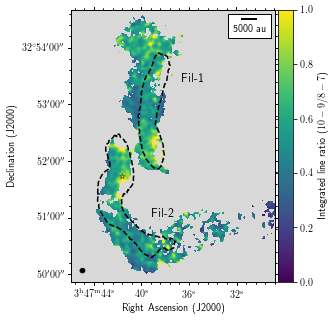

In [113]:
savefigure = True
fig = plt.figure(figsize=(5,5))
figname = figdir + 'B5_NOEMA_30m_10-9_over_8-7.pdf'

gc = plot_aplpy_subfig(ratiomapfile, fig, (1,1,1), 'linear', 0, 1, 'viridis', showframeScalebar=True)

# filament outline from NH3(1,1)
gc.show_contour(nh3mom0file, colors='k', linestyles='dashed', levels=nh3mom0levels, zorder=34)
gc.add_label(0.6, 0.75, 'Fil-1', relative=True, color='k', size=12)
gc.add_label(0.45, 0.25, 'Fil-2', relative=True, color='k', size=12)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
# gc.add_label(0.99,0.20, 'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (10 - 9)', relative=True, color='w', size=10, horizontalalignment='right')
gc.colorbar.set_axis_label_text(r'Integrated line ratio ($10-9/8-7$)')

# gc.show_rectangles([ra_yso], [dec_yso], 0.0015*2, 0.0015*2, edgecolor='k', facecolor='none')

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

## HC$_3$N ($8-7$)

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)


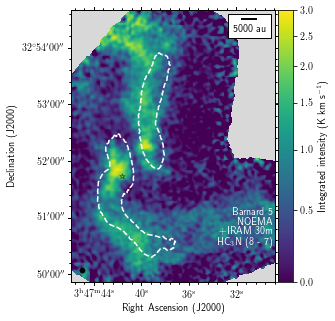

In [112]:
savefigure = True
fig = plt.figure(figsize=(5,5))
figname = figdir + imagefile_87 + '_mom0_9.2_11.2.pdf'

gc = plot_aplpy_subfig(mom0file87+'.fits', fig, (1,1,1), 'arcsinh', 0, 3, 'viridis', vmid=1, showframeScalebar=True)
# gc.show_contour(maskC1file, colors='w', linewidths=0.5)
# gc.add_label(0.55, 0.55, 'Cond-1', relative=True, color='w', size=12)
# gc.show_contour(maskC2file, colors='w', linewidths=0.5)
# gc.add_label(0.15, 0.58, 'Cond-2', relative=True, color='w', size=12)
# gc.show_contour(maskC3file, colors='w', linewidths=0.5)
# gc.add_label(0.35, 0.29, 'Cond-3', relative=True, color='w', size=12)

# gc.show_arrows([56.9071283, 56.9275561, 56.9212545, 56.9039327, 56.9074336], 
#                [32.8742579, 32.8753517, 32.8564551, 32.8903704, 32.8489104], 
#                [0.005, -0.003, 0.006, 0.006, 0.006], [-0.001, -0.008, 0.003, 0, -0.006], color='w', width=1, head_width=4, head_length=4)
# filament outline from NH3(1,1)
gc.show_contour(nh3mom0file, colors='w', linestyles='dashed', levels=nh3mom0levels, zorder=34)
# gc.add_label(0.6, 0.75, 'Fil-1', relative=True, color='w', size=12)
# gc.add_label(0.51, 0.25, 'Fil-2', relative=True, color='w', size=12)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.add_label(0.99,0.20, 'Barnard 5\nNOEMA\n+IRAM 30m\nHC$_3$N (8 - 7)', relative=True, color='w', size=10, horizontalalignment='right')
gc.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')

# gc.show_rectangles([ra_yso], [dec_yso], 0.0015*2, 0.0015*2, edgecolor='k', facecolor='none')

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

## H$_2$CO (1$_{0,1}$ -- 0$_{0,0}$)

### Moment 0

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found w

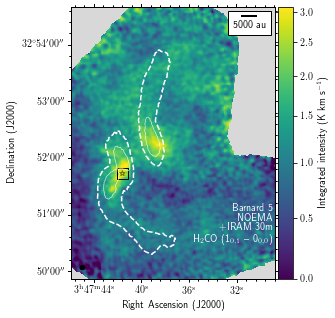

In [36]:
savefigure = True
fig = plt.figure(figsize=(5,5))
figname = figdir + imagefileh2co + '_mom0_9.2_11.0.pdf'

gc = plot_aplpy_subfig(mom0h2cofile, fig, (1,1,1), 'arcsinh', 0, 3.1, 'viridis', vmid=1.5, showframeScalebar=True)
gc.show_contour(maskC1file, colors='w', linewidths=0.5)
gc.show_contour(maskC2file, colors='w', linewidths=0.5)
gc.show_contour(maskC3file, colors='w', linewidths=0.5)

# filament outline from NH3(1,1)
gc.show_contour(nh3mom0file, colors='w', linestyles='dashed', levels=nh3mom0levels, zorder=34)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
gc.add_label(0.99,0.20, 'Barnard 5\nNOEMA\n+IRAM 30m\nH$_2$CO (1$_{0,1}$ -- 0$_{0,0}$)', relative=True, color='w', size=10, horizontalalignment='right')
gc.colorbar.set_axis_label_text(r'Integrated intensity (K km s$^{-1}$)')
#show alma box
gc.show_rectangles([ra_yso], [dec_yso], 0.0015*2, 0.0015*2, edgecolor='k', facecolor='none')

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

### Results of the 1 Gaussian fit to H$_2$CO

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data 

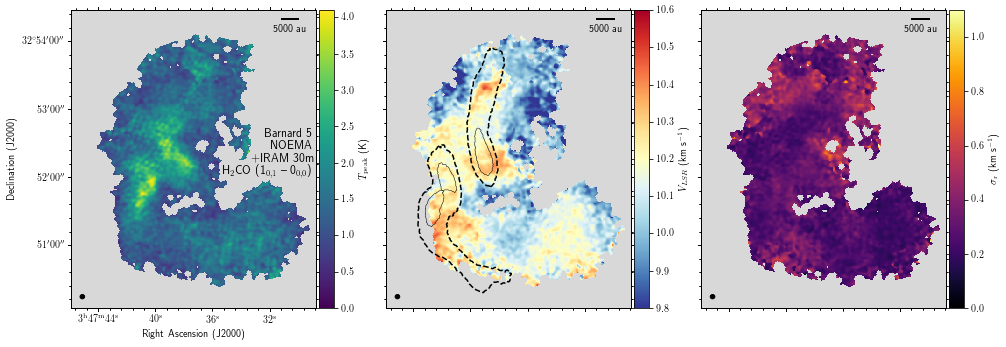

In [37]:
savefigure = True

fig = plt.figure(1, figsize=(16,8))
figname = figdir + imagefileh2co + '_1G_fitparams_filtered_results.pdf'

cube = fits.getdata(fitfilefilteredh2co)
paramscube = cube[:3]
errcube = cube[3:]
headerplot = fits.getheader(tpeakfile + '.fits')
stretch = 'linear'
vmin = [0, 10.2-0.4, 0]
vmax = [np.round(np.nanmax(paramscube[0]), 1), 10.2+0.4, np.round(np.nanmax(paramscube[2]), 1)]
cmap = ['viridis', 'RdYlBu_r', 'inferno']
quantities = [r'$T_{\mathrm{peak}}$ (K)', r'$V_{LSR}$ (km s$^{-1}$)', r'$\sigma_{\mathrm{r}}$ (km s$^{-1}$)']

for i in range(len(paramscube)):
    ax0 = plot_aplpy_subfig(fits.PrimaryHDU(paramscube[i], headerplot), fig, (1,3,i+1), stretch, \
                            vmin[i], vmax[i], cmap[i])
    ax0.colorbar.set_axis_label_text(quantities[i])
    ax0.recenter(56.9055921,32.8711272,width=0.06,height=0.073)
    if i:
        ax0.tick_labels.hide()
        ax0.axis_labels.hide()
    else:
        ax0.add_label(0.99,0.52, 
                     'Barnard 5\nNOEMA\n+IRAM 30m\nH$_2$CO (1$_{0,1}$ -- 0$_{0,0}$)', 
                     relative=True, color='k', size=12, horizontalalignment='right')
    if i==1:
        ax0.show_contour(maskC1file, colors='k', linewidths=0.5)
        ax0.show_contour(maskC2file, colors='k', linewidths=0.5)
        ax0.show_contour(maskC3file, colors='k', linewidths=0.5)
        # filament outline from NH3(1,1)g
        ax0.show_contour(nh3mom0file, colors='k', linestyles='dashed', levels=nh3mom0levels, zorder=34)

if savefigure:
    fig.savefig(figname, bbox_inches='tight', dpi=300)

## NH$_3$

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("viridis").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found w

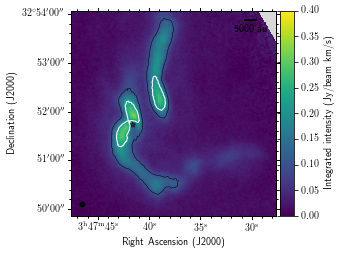

In [38]:
savefigure = True
fig = plt.figure(figsize=(4,5))
figname = figdir + 'NH311_mom0_wcond.pdf'
gc = plot_aplpy_subfig(nh3mom0file, fig, (1,1,1), 'linear', 0, 0.4, 'viridis')
gc.recenter(56.9067231, 32.8660922, 0.035)
gc.show_contour(maskC1file, colors='w', linewidths=1)
gc.show_contour(maskC2file, colors='w', linewidths=1)
gc.show_contour(maskC3file, colors='w', linewidths=1)
gc.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.colorbar.set_axis_label_text(r'Integrated intensity (Jy/beam km/s)')
if savefigure: 
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found 

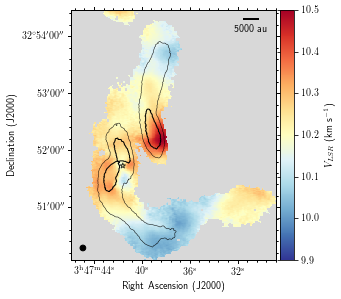

In [39]:
# velocity fit of NH3, in the same absolute scale as HC3N
fig = plt.figure(figsize=(4,5))
figname = figdir + 'NH311_dv_wcont.pdf'
gc = plot_aplpy_subfig(nh3velocityfile, fig, (1,1,1), 'linear', 9.9, 10.5, 'RdYlBu_r')
# gc.recenter(56.9067231, 32.8660922, 0.035)
gc.recenter(56.9055921,32.8711272,width=0.06,height=0.073)
gc.show_contour(maskC1file, colors='k', linewidths=1)
gc.show_contour(maskC2file, colors='k', linewidths=1)
gc.show_contour(maskC3file, colors='k', linewidths=1)
gc.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')

gc.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found 

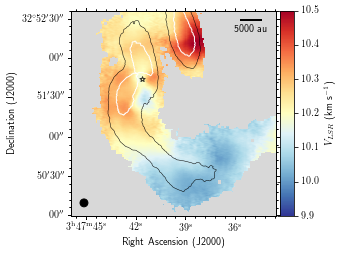

In [40]:
# zoomed velocity fit of NH3, in the same absolute scale as HC3N
fig = plt.figure(figsize=(4,5))
figname = figdir + 'NH311_dv_wcont_south.pdf'
gc = plot_aplpy_subfig(nh3velocityfile, fig, (1,1,1), 'linear', 9.9, 10.5, 'RdYlBu_r')
gc.recenter(56.9067231, 32.8660922, 0.035)
gc.show_contour(maskC1file, colors='w', linewidths=1)
gc.show_contour(maskC2file, colors='w', linewidths=1)
gc.show_contour(maskC3file, colors='w', linewidths=1)
gc.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9154585, 32.8549649, 0.0217241) #we focus on the south filament
gc.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)


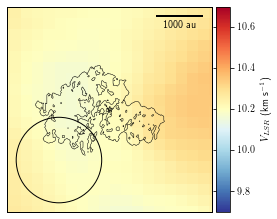

In [101]:
# zoomed velocity fit of NH3, compared to the ALMA streamer
savefig = True
fig = plt.figure(figsize=(4,5))
figname = figdir + 'NH311_dv_ALMAcontour.pdf'

stretch = 'linear'
vmin = 10.2-0.5
vmax = 10.2+0.5

gc = plot_aplpy_subfig(nh3velocityfile, fig, (1,1,1), stretch, vmin, vmax, 'RdYlBu_r', barsize=1000)
gc.ticks.hide()
gc.tick_labels.hide()
gc.axis_labels.hide()
gc.recenter(ra_yso, dec_yso, 0.002)
gc.beam.set_facecolor('None')
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.colorbar.set_axis_label_text(r'$V_{LSR}$ (km s$^{-1}$)')
gc.show_contour(fits.PrimaryHDU(tpeak, tpeakheader), colors='k', levels=[0.5], linewidths=0.5)
if savefig:
    fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found 

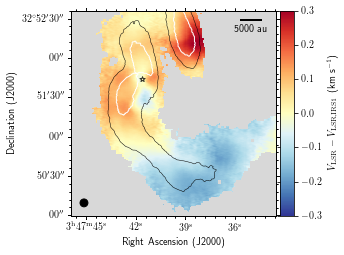

In [41]:
# zoomed image of the velocity difference with IRS1
vlsr_irs1 = 10.2 #km/s
diffvlsr = fits.getdata(nh3velocityfile) - vlsr_irs1
fig = plt.figure(figsize=(4,5))
figname = figdir + 'NH311_diff_wcont_south.pdf'
gc = plot_aplpy_subfig(fits.PrimaryHDU(diffvlsr, fits.getheader(nh3velocityfile)), fig, (1,1,1), 'linear', -.3, .3, 'RdYlBu_r')
gc.recenter(56.9067231, 32.8660922, 0.035)
gc.show_contour(maskC1file, colors='w', linewidths=1)
gc.show_contour(maskC2file, colors='w', linewidths=1)
gc.show_contour(maskC3file, colors='w', linewidths=1)
gc.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
gc.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
gc.recenter(56.9154585, 32.8549649, 0.0217241) #we focus on the south filament
gc.colorbar.set_axis_label_text(r'$V_{\mathrm{LSR}} - V_{\mathrm{LSR}, \mathrm{IRS1}}$ (km s$^{-1}$)')

## Velocity from the Gaussian fit minus velocity of NH$_3$ Gaussian fit from Pineda+2015

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("RdYlBu_r").copy()
  cm.set_bad(color)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found within the data range.
  cset = super().contour(*args, **kwargs)
/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/astropy/visualization/wcsaxes/core.py:235: UserWarning: No contour levels were found 

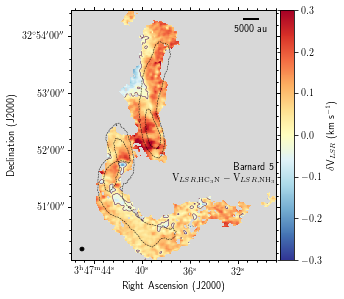

In [42]:
savefigure = True
fig = plt.figure(figsize=(4,8))
figname = figdir + 'B5_HC3N_minus_NH3.pdf'
velmin = -0.3
velmax = 0.3
ax = plot_aplpy_subfig(vlsrdifffile, fig, (1,1,1), 'linear', velmin, 
                       velmax, 'RdYlBu_r')
ax.show_contour(vlsrdifffile, levels=[0], linewidths=0.5)
ax.show_contour(maskC1file, colors='k', linewidths=0.5, linestyles='dashed')
ax.show_contour(maskC2file, colors='k', linewidths=0.5, linestyles='dashed')
ax.show_contour(maskC3file, colors='k', linewidths=0.5, linestyles='dashed')
ax.recenter(56.9055921,32.8711272,width=0.06,height=0.08)
ax.show_contour(nh3mom0file, colors='k', linewidths=0.5, linestyles='dashed', levels=nh3mom0levels, zorder=34)
# ax.colorbar.set_axis_label_text(r'$V_{\mathrm{LSR},\mathrm{HC}_3\mathrm{N}(10-9)} - V_{\mathrm{LSR}, \mathrm{NH}_3(1,1)}$ (km s$^{-1}$)')
ax.colorbar.set_axis_label_text(r'$\delta$V$_{LSR}$ (km s$^{-1}$)')
ax.recenter(56.9055921,32.8711272,width=0.06,height=0.073)
# ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.5, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.add_label(0.99,0.35, 'Barnard 5\n$\mathrm{V}_{LSR, \mathrm{HC}_3\mathrm{N}} - \mathrm{V}_{LSR, \mathrm{NH}_3}$', relative=True, color='k', size=10, horizontalalignment='right')
# ax.show_contour(nh3mom0file, colors='black', linewidths=0.5, levels=nh3mom0levels, zorder=34)
if savefigure:
    fig.savefig(figname, bbox_inches='tight')


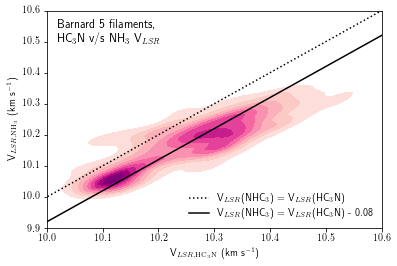

In [43]:
# 2D KDE of the velocities
savefigure = True
figname = figdir + 'B5_HC3N_v_lsr_compared_NH3.pdf'

xx, yy, zz = np.load(vlsrdiffkdefile+'_2DKDE.npy')
def shifted_line(velx, shift):
    return velx + shift

linesample = np.linspace(9.8, 10.8, 10)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.contourf(xx, yy, zz, cmap='RdPu', levels=np.arange(0.1, 1.2, 0.1), vmin=0., vmax=1.1)
ax.plot(linesample, linesample, 'k:', label='V$_{LSR}$(NHC$_{3}$) = V$_{LSR}$(HC$_3$N)')
ax.plot(linesample, shifted_line(linesample, -0.08), 'k-', label='V$_{LSR}$(NHC$_{3}$) = V$_{LSR}$(HC$_3$N) - 0.08')
ax.set_xlabel(r'V$_{LSR, \mathrm{HC}_3\mathrm{N}}$ (km s$^{-1}$)')
ax.set_ylabel(r'V$_{LSR, \mathrm{NH}_3}$ (km s$^{-1}$)')
ax.text(10.02, 10.5, 'Barnard 5 filaments,\n HC$_3$N v/s NH$_{3}$ V$_{LSR}$', size=12)
ax.set_xlim([10, 10.6])
ax.set_ylim([9.9, 10.6])
ax.legend(frameon=False, loc=4)
# $\mathrm{V}_{LSR, \mathrm{HC}_3\mathrm{N}} - \mathrm{V}_{LSR, \mathrm{NH}_3}$
if savefigure:
    fig.savefig(figname, bbox_inches='tight')

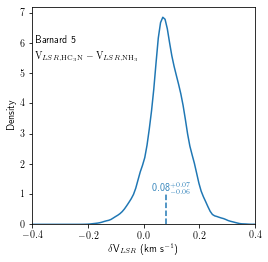

In [44]:
# KDE of the velocity difference

fig = plt.figure(figsize=(4,4))
figname = figdir + 'B5_HC3N_minus_NH3_kde.pdf'
data, dens, vlsr_median_unc = np.load(vlsrdiffkdefile+'.npy', allow_pickle=True)

ax = fig.add_subplot(111)
# ax.hist(data, fc='k', bins='sturges', density=True)
ax.plot(data, dens)
ax.plot([vlsr_median_unc[1], vlsr_median_unc[1]], [0, 1], color='C0', ls='--')
ax.text(vlsr_median_unc[1]-0.05,1.1,r'{0}$_{{{1:.2f}}}^{{+{2:.2f}}}$'.format(vlsr_median_unc[1], vlsr_median_unc[0]-vlsr_median_unc[1], vlsr_median_unc[2]-vlsr_median_unc[1]), size=10, color='C0')

ax.set_xlabel(r'$\delta$V$_{LSR}$ (km s$^{-1}$)')
ax.set_ylabel('Density')
ax.set_xlim([-0.4, 0.4])
ax.set_ylim(bottom=0)
ax.text(-0.39, 6, 'Barnard 5', size=10)
ax.text(-0.39, 5.5, '$\mathrm{V}_{LSR, \mathrm{HC}_3\mathrm{N}} - \mathrm{V}_{LSR, \mathrm{NH}_3}$')

fig.savefig(figname, bbox_inches='tight')

## Velocity dispersion from the Gaussian fit minus velocity of NH$_3$ Gaussian fit from Pineda+2015

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)


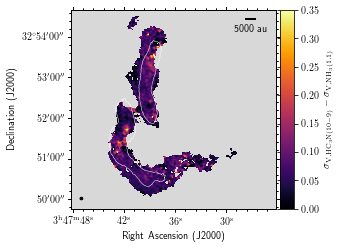

In [45]:
fig = plt.figure(figsize=(4,4))
figname = figdir + 'B5_SigmaV_HC3N_minus_NH3.pdf'
velmin = 0
velmax = 0.35
ax = plot_aplpy_subfig(sigmavdifffile, fig, (1,1,1), 'linear', velmin, 
                       velmax, 'inferno')
# ax.show_contour(vlsrdifffile, levels=[0], linewidths=0.5)

ax.show_contour(nh3mom0file, colors='w', linewidths=0.5, levels=nh3mom0levels, zorder=34)
ax.colorbar.set_axis_label_text(r'$\sigma_{\mathrm{V},\mathrm{HC}_3\mathrm{N}(10-9)} - \sigma_{\mathrm{V}, \mathrm{NH}_3(1,1)}$')
fig.savefig(figname, bbox_inches='tight')

/home/mvaldivi/anaconda3/envs/python3/lib/python3.9/site-packages/aplpy/core.py:787: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. This has been deprecated since 3.3 and in 3.6, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = mpl.cm.get_cmap("inferno").copy()
  cm.set_bad(color)


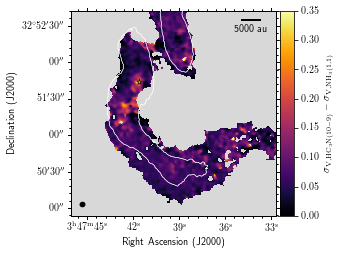

In [46]:
# same but zoomed to the south
fig = plt.figure(figsize=(4,4))
figname = figdir + 'B5_SigmaV_HC3N_minus_NH3_south.pdf'
velmin = 0
velmax = 0.35
ax = plot_aplpy_subfig(sigmavdifffile, fig, (1,1,1), 'linear', velmin, 
                       velmax, 'inferno')
# ax.show_contour(vlsrdifffile, levels=[0], linewidths=0.5)
ax.show_contour(nh3mom0file, colors='w', linewidths=0.5, levels=nh3mom0levels, zorder=34)

ax.show_contour(nh3mom0file, colors='w', linewidths=0.5, levels=nh3mom0levels, zorder=34)
ax.recenter(56.9139998, 32.8550135, 0.0234465)
ax.show_markers(ra_yso, dec_yso, marker='*', alpha=0.8, layer='lay_yso',  facecolor='None', edgecolor='k')
ax.colorbar.set_axis_label_text(r'$\sigma_{\mathrm{V},\mathrm{HC}_3\mathrm{N}(10-9)} - \sigma_{\mathrm{V}, \mathrm{NH}_3(1,1)}$')

fig.savefig(figname, bbox_inches='tight')